In [53]:
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image
import matplotlib.pyplot as plt
from sympy import RegularPolygon, Point2D,pi,symbols,sin,sqrt
from shapely.geometry import Polygon,MultiPolygon
from shapely import affinity
from time import time
from random import choices,randint,shuffle
import numpy as np

### Puzzle as published 
https://www.janestreet.com/puzzles/pent-up-frustration-2-index/

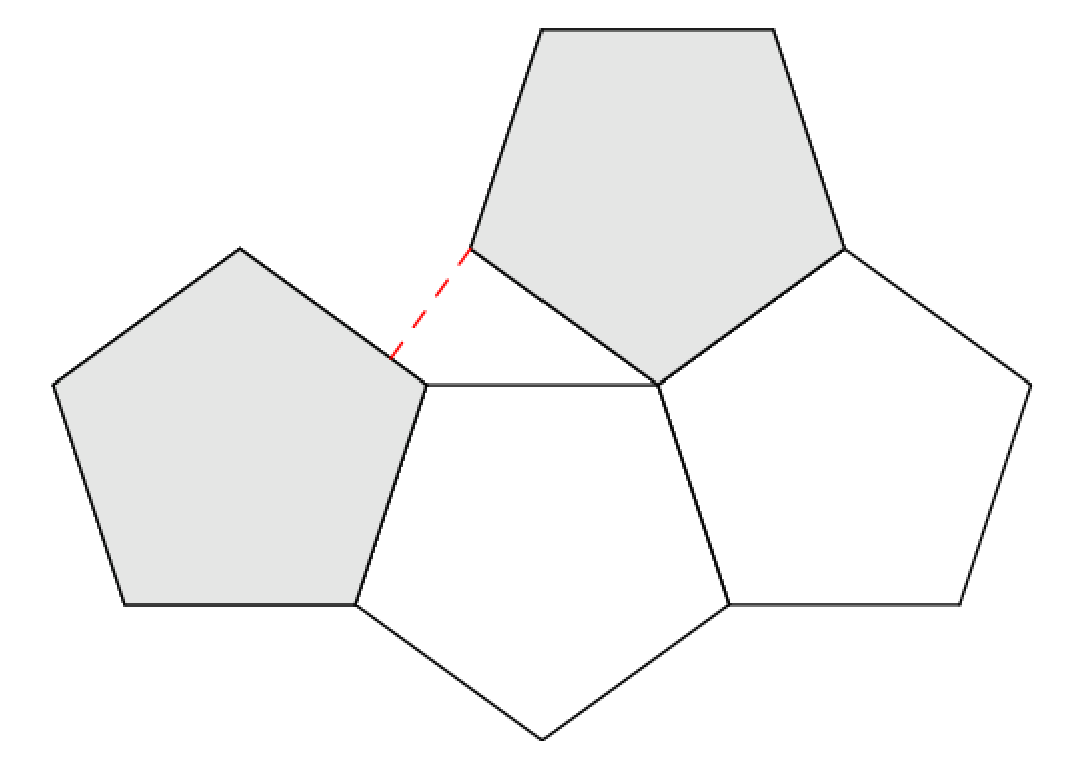

In [2]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-2-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/pent-up-frustration-2.png',width=400))
HTML(str(soup.find_all('div', {'class' :'col-12'})[4]))

In [3]:
#some code to visualise
def plot_polys(polys):
    fig,ax= plt.subplots(1,1,figsize=(5,5))
    for poly in polys:        
        plot_coords(poly.exterior.coords)
    ax.axis("off")
        
def plot_coords(coords):
    pts = list(coords)
    x, y = zip(*pts)
    plt.plot(x,y, color='k', linewidth=1)
    plt.fill_between(x, y)
    plt.show   

In [4]:
# sympy geometry is too slow. Use the Regular Pentagon to get the vertices easily and then
# use shapely from there
n = RegularPolygon(Point2D(0,0), 1/(2*sin(pi/5)), 5,rot=pi/2)
p= Polygon([(e.x,e.y) for e in n.vertices])

def new_pent(p,i):
    verts = [*p.exterior.coords]
    centroid_x = p.centroid.x
    centroid_y =p.centroid.y
    mid_x =(verts[i][0]+verts[i+1][0])/2
    mid_y =(verts[i][1]+verts[i+1][1])/2
    trans_x = 2*(mid_x-centroid_x)
    trans_y = 2*(mid_y-centroid_y)
    return affinity.rotate(affinity.translate(p,trans_x,trans_y),180,origin='centroid')

Distance is 0.0000000


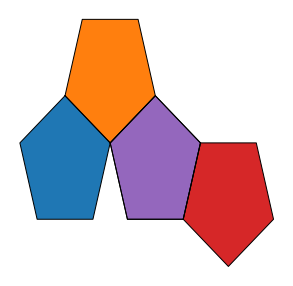

In [128]:
# check the test puzzle
pents = [p]
edges =[0, 1, 4, 4]
for i in edges:
    pents.append(new_pent(pents[-1],i))
    
plot_polys(pents)  

print("Distance is {:.7f}".format(pents[0].distance(pents[-1])))

In [ ]:
#see if I can find the answer by trying randomly

start= time()
N = 17
best_len = 10
trials = [[p,new_pent(p,0)]]

while len(trials) >0 and time()-start <60*60*3 and best_len >0.14:
    pents=trials.pop()
    if len(pents) <= N:
        choices = [i for i in range(5)]
        shuffle(choices)
        for i in choices:
            test_pent = new_pent(pents[-1],i)
            if np.all([p.overlaps(test_pent.buffer(-0.001))==False for p in pents]):        
                trials.append(pents+[test_pent])
    else:
        dist = pents[0].distance(pents[-1])
        if dist < best_len-0.000001 and dist > 0.000000001:
            best_len = dist
            best_pent = pents        
            print("Distance {:.7f} in {:.6f} secs".format(pents[0].distance(pents[-1]),time()-start))

plot_polys(best_pent)

Distance is 0.1387573


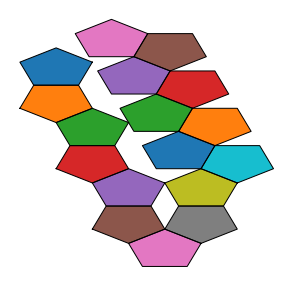

In [177]:
# published answer. Didn't spend enough time on this this month.

pents = [p]
edges =[3,1,3,1,3,1,
        0,3,
        0,4,0,4,0,4,0,4]
for i in edges:
    pents.append(new_pent(pents[-1],i))
    
plot_polys(pents)  

print("Distance is {:.7f}".format(pents[0].distance(pents[-1])))

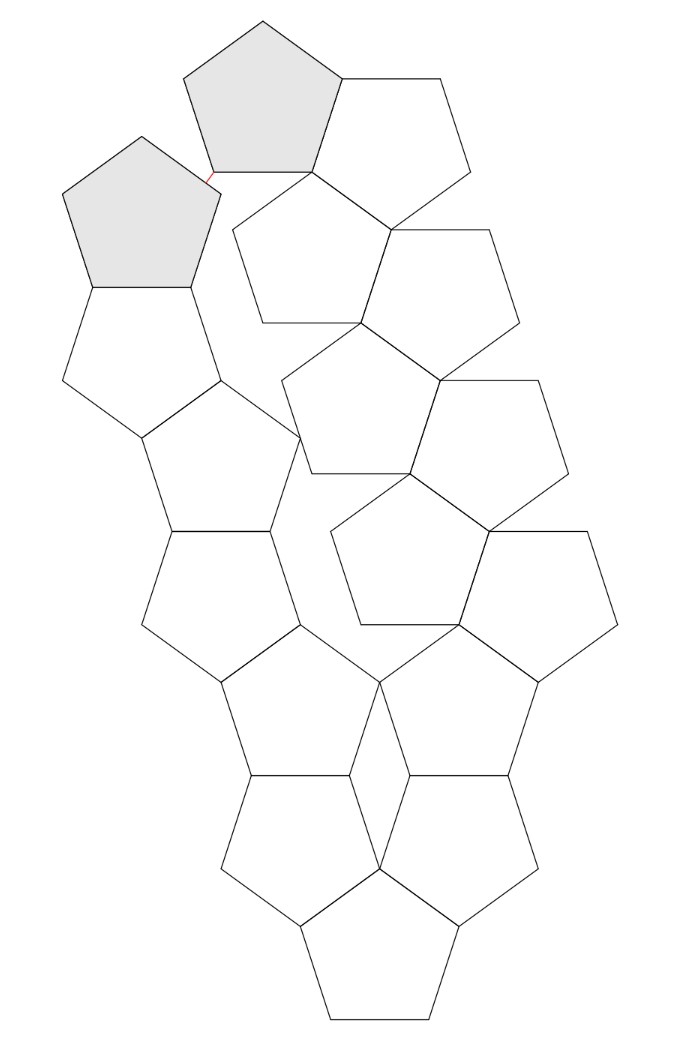

### Solution as published 
https://www.janestreet.com/puzzles/pent-up-frustration-2-solution/

In [176]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')

display(Image('https://www.janestreet.com/puzzles/pent-up-frustration-2-solution.png',width=200))
display(Markdown('### Solution as published \n'+url))
HTML(str(soup.find_all('div', {'class' :'col-12'})[4]))

0.951056516295158 distance found after 0.08137321472167969 seconds.

0.22451398828979735 distance found after 0.1627199649810791 seconds.

0.13875727571288146 distance found after 0.2833271026611328 seconds.


Shortest distance for 17 pentagons found was: 0.13875727571288146




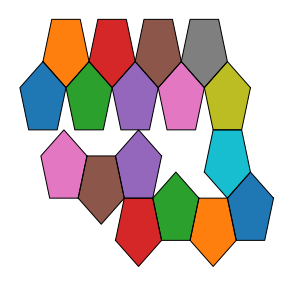

In [185]:
'''
Sped up answer by doing a couple of things:
  1) Cut run time in half by only trying two positions for the 3rd move
     since the other two can be eliminated by symmetry
  2) Eliminating it trying to put the next pentagon onto the spot that the
     previous pentagon was hooked on its 'parent' pentagon and thus cut down
     number of spots to check by 20%
  3) Eliminated it checking overlap between last two pentagons placed since we
     have already guarenteed it won't overlap with the the 'parent' of the most
     recent pentagon and it is impossible to overlap with the one we are hooking
     it onto which at the worst case (when there are already 16 placed), reduces 
     amount to check by 12.5% and at the best case (when there are 2 placed),
     eliminates 100% of overlap checks needed 
  4) Got rid of the random shuffle when trying positions because that seemed like
     an uneccessary step
  5) Previously the program did not only add on a pentagon to the most recently
     placed one and tried placing a new one on every other pentagon already placed
     (or at least I think that's what it was doing when I was trying to debug by
     printing out different outputs) which added on an astronomical amount of time
  6) I stopped the recursive calls early by only continuing to go if the shape would
     have a chance at 'looping back' to the first placed pentagon and leave a
     reasonable distance. I'm probably not articulating this very well but I left
     a comment in the code where this was done. Unsure how much this helps by, but it
     sped up the code by a massive amount

Some places for improvement:
  1) I'm not very familiar with libraries like Numba, but perhaps there is a
     place where a library like that could help here?
  2) It's been a while since I've coded in Python in a while, but I was unable
     to append stuff to the parameters without making a copy of them each time,
     appending stuff to the copies, and then passing those copies to the
     recursive calls- this should be able to be eliminated I think?
  3) It finds the correct answer very quickly (after about 0.3 seconds), but by
     my rough estimates of how the times seem to scale, it would take a little
     over 2 hours to guarentee that this is the correct answer- there should be
     some more ways to reduce total it has to check my symmetry to lower the
     time taken to guarentee that this is the correct answer
'''


N = 17
start_time = time()
start = [p, new_pent(p, 0)]
distances_and_shapes = [1, []]


def solve(pents, prev, shape):
  if len(pents) == N or time()-start_time > 60:
    sol = pents[0].distance(pents[-1])
    if sol > 0.0001 and sol < distances_and_shapes[-2]:
      print(f"{sol} distance found after {time()-start_time} seconds.\n")
      distances_and_shapes.append(sol)
      distances_and_shapes.append(shape)
  elif len(pents) == 2:
    # by symmetry you only need to try two for the third one
    for i in [1, 2]:
      test_pent = new_pent(pents[-1], i)
      a = pents.copy(); a.append(test_pent)
      b = shape.copy(); b.append(i)
      solve(a, i, b)
  # this prevents chains that have no chance at "looping back" from developing
  elif pents[0].distance(pents[-1]) < (N - len(pents)) * 1.4:
    for i in [0, 1, 2, 3, 4]:
      # you don't need to try the spot where you know it can't be attached
      if i != prev:
        test_pent = new_pent(pents[-1], i)
        # we already know that it can't overlap with most recent and it also can't
        # overlap with second to most recent either
        if np.all([pents[i].overlaps(test_pent.buffer(-0.001))==False for i in range(len(pents) - 2)]):
          a = pents.copy(); a.append(test_pent)
          b = shape.copy(); b.append(i)
          solve(a, i, b)


solve(start, 0, [0])
print(f"\nShortest distance for {N} pentagons found was: {distances_and_shapes[-2]}\n\n")
sol = [p]
for i in distances_and_shapes[-1]:
  sol.append(new_pent(sol[-1],i))
plot_polys(sol)